In [82]:
import pandas as pd
%matplotlib inline

c = pd.read_csv("https://projects.fivethirtyeight.com/2020-general-data/presidential_scenario_analysis_2020.csv")
filtered_scenarios = c[(c.scenario_description == "Biden wins popular vote") | (c.scenario_description == "Trump wins popular vote")]
df = filtered_scenarios[['scenario_description', 'probability', 'modeldate']]
df['scenario_description'] = df.scenario_description.str.extract("(^.+?) ")
wide_df = df.pivot(index = 'modeldate', columns = 'scenario_description', values='probability')

C:\Users\Willy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


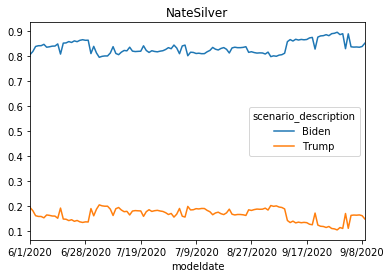

In [83]:
wide_df.plot(title='NateSilver')